In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df = pd.read_csv('training_data_filled_11.09.csv')
df.drop(columns=['prepayment'], inplace=True)

### Синтезируем признаки

In [3]:
df['penalty_per_day'] = [
    claimed_penalty / delay
    for (claimed_penalty, delay)
    in df[['claimed_penalty', 'delay']].values
]
df['price_per_penalty'] = [
    contract_price / claimed_penalty
    for (contract_price, claimed_penalty)
    in df[['contract_price', 'claimed_penalty']].values
]
df['price_per_debt'] = [
    contract_price / debt_amount
    for (contract_price, debt_amount)
    in df[['contract_price', 'debt_amount']].values
]

### Добавляем категориальные признаки

In [4]:
def transform_into_onehot(column_name, df):
    encoding_dict = {
        c: i for (i, c) in enumerate(df[column_name].unique())
    }
    encoded = np.zeros((len(df), len(encoding_dict)))
    for i, val in enumerate(df[column_name]):
        one_place = encoding_dict[val]
        encoded[i][one_place] = 1
    return encoded

encoded_type_of_contract = transform_into_onehot('type_of_contract', df)
encoded_appeal_courts = transform_into_onehot('appeal_courts', df)
encoded_judge_gender = transform_into_onehot('judge_gender', df)
encoded_year = transform_into_onehot('year', df)

In [5]:
features = df[[
    'claimed_penalty', 'contract_penalty_percentage', 'contract_price', 'delay',
    'debt_amount', 'penalty_per_day', 'price_per_penalty', 'price_per_debt'
]].values

features = np.hstack([features, encoded_type_of_contract, encoded_appeal_courts, encoded_judge_gender, encoded_year])

### Autorncoder

In [6]:
features.shape

(125, 30)

In [19]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(30, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

    
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc3 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [21]:
data = torch.tensor(features).float()

In [22]:
for i in range(len(data[0])):
    data[:, i] = data[:, i] / sum(data[:, i])

In [23]:
net = Autoencoder()
net

Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=30, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=20, bias=True)
    (fc3): Linear(in_features=20, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=30, bias=True)
  )
)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [25]:
for i in range(20): # кол-во эпох
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()
    if i % 1 == 0:
        print(loss.item())

0.09282078593969345
0.022854529321193695
0.01806720159947872
0.02621239610016346
0.02827535569667816
0.022696197032928467
0.01579934172332287
0.011487272568047047
0.009820148348808289
0.009169169701635838
0.008527500554919243
0.007871730253100395
0.007414872292429209
0.0071434215642511845
0.0068505206145346165
0.006351647898554802
0.0056280032731592655
0.004813228268176317
0.004076193552464247
0.0035249528009444475


/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Получаем значения скрытого слоя

In [26]:
embeddings = net.encoder(data)

### Визуализация

In [27]:
import matplotlib.pyplot as plt

In [28]:
embeddings = embeddings.detach().numpy()

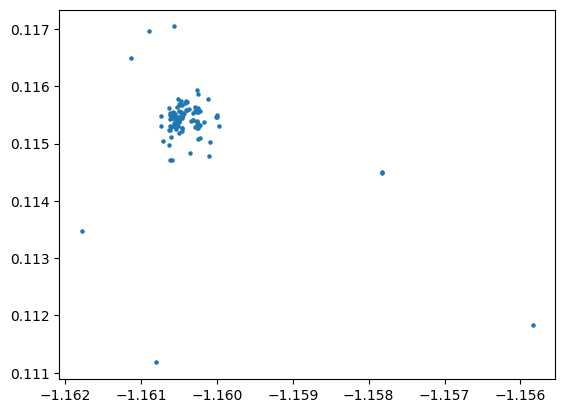

In [29]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker='.', s=20)
plt.show()